In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np #for working with arrays, it has functions for working in domain of linear algebra
import pandas as pd  #for working with datasets
from sklearn.dummy import DummyClassifier #makes predictions ignoring the input features.

#For exploratory data analysis
from wordcloud import WordCloud #Text data visualization
import matplotlib.pyplot as plt #Plotting
import seaborn as sns #Statistical graphing

#Data Preprocessing
import re #Regular expression operations
from sklearn.pipeline import Pipeline #assemble several steps
from sklearn.feature_extraction.text import TfidfVectorizer #Text vectorization to numerical features
from sklearn.decomposition import TruncatedSVD #Dimensionality reduction
from sklearn.preprocessing import StandardScaler #Data scaling
from sklearn.model_selection import train_test_split #Data splitting into train and validation.
from sklearn.preprocessing import LabelBinarizer #Categorical data encoding

#Hypertuning of parameters
from sklearn.model_selection import GridSearchCV #exhaustively considers all parameter combinations
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import RandomizedSearchCV #samples a given number of candidates from a parameter space with a specified distribution

#Model Training
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

#Model Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, classification_report, PrecisionRecallDisplay


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


In [2]:
#Reading the input files and storing in the form of dataframe
trainingData=pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv')
MovieData=pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv')
testData=pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')

In [ ]:
#Building a Dummy Model with considering input features
y=trainingData.sentiment
X=trainingData.drop('sentiment',axis=1)
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)

prediction=dummy_clf.predict(testData)
print(prediction)

dummy_clf.score(X, y)

In [ ]:
# submission = pd.DataFrame(columns = ['id','sentiment'])
# submission['id']=[i for i in range(len(prediction))]
# submission['sentiment']=prediction
# submission.to_csv('submission.csv', index=False)

In [3]:
joined_trainData = MovieData.merge(trainingData,on=["movieid"])
# print(joined_trainData.head(10))
# joined_trainData.dtypes

In [4]:
print(joined_trainData.describe())
print(joined_trainData.info())

       audienceScore  runtimeMinutes
count  224448.000000   302589.000000
mean       63.288659      102.556332
std        21.026355       26.051562
min         0.000000        2.000000
25%        48.000000       90.000000
50%        67.000000      100.000000
75%        81.000000      115.000000
max       100.000000      561.000000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 525277 entries, 0 to 525276
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               525277 non-null  object 
 1   title                 525277 non-null  object 
 2   audienceScore         224448 non-null  float64
 3   rating                134486 non-null  object 
 4   ratingContents        134486 non-null  object 
 5   releaseDateTheaters   182326 non-null  object 
 6   releaseDateStreaming  249433 non-null  object 
 7   runtimeMinutes        302589 non-null  float64
 8   genre                 307944 no

In [5]:
print(testData.describe())
print(testData.info())

                                            movieid     reviewerName  \
count                                         55315            55315   
unique                                        16786             4495   
top     escape_the_terminator_tyler_durden_astonish  Sherri Morrison   
freq                                            230              428   

       isTopCritic               reviewText  
count        55315                    52805  
unique           2                    52686  
top          False  Parental Content Review  
freq         38428                       12  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55315 entries, 0 to 55314
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movieid       55315 non-null  object
 1   reviewerName  55315 non-null  object
 2   isTopCritic   55315 non-null  bool  
 3   reviewText    52805 non-null  object
dtypes: bool(1), object(3)
memory usage: 1.3+ MB


In [6]:
feature = joined_trainData[['movieid','reviewerName','isFrequentReviewer','reviewText']].copy()
label = joined_trainData[['sentiment']]

In [7]:
trainData=joined_trainData[['reviewText','sentiment']].copy()
testData=testData[['reviewText']].copy()

In [8]:
trainData=trainData.convert_dtypes()
testData=testData.convert_dtypes()

In [9]:
print(trainData.dtypes)
print(testData.dtypes)

reviewText    string
sentiment     string
dtype: object
reviewText    string
dtype: object


Text(0, 0.5, 'Count')

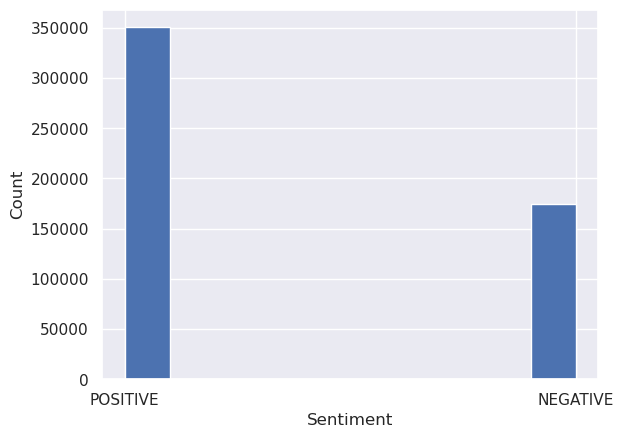

In [10]:
sns.set()
trainData.sentiment.hist()
plt.xlabel('Sentiment')
plt.ylabel('Count')

**Text pre-processing**

In [11]:
#Text Cleaning
def denoise_text(text):
    #Removing special characters
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    #Removing the square brackets
    text = re.sub('\[[^]]*\]', '', text)
    #Text Stemming
    text = re.sub(r'ing|les|ly|es|s|ed', '', text)
    #Tokenization
    pattern = r'\b\w+\b'  # Matches word boundaries
    tokens = re.findall(pattern, text)
    #Joining the text
    filtered_text = ' '.join(tokens)    
    return filtered_text

In [12]:
trainData.reviewText = trainData.reviewText.fillna('') #Data Imputation
trainData['reviewText']=trainData['reviewText'].apply(denoise_text)

testData.reviewText = testData.reviewText.fillna('') #Data Imputation
testData['reviewText']=testData['reviewText'].apply(denoise_text)

**Text-Words analysis using Word Cloud**

In [14]:
posText=str(trainData[trainData.sentiment=='POSITIVE'].reviewText)
negText=str(trainData[trainData.sentiment=='NEGATIVE'].reviewText)

(-0.5, 399.5, 199.5, -0.5)

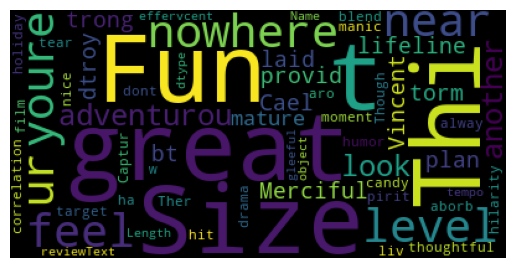

In [15]:
wc_pos=WordCloud().generate(posText)
plt.imshow(wc_pos)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

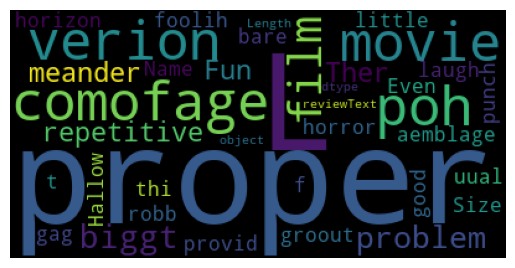

In [16]:
wc_neg=WordCloud().generate(negText)
plt.imshow(wc_neg)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

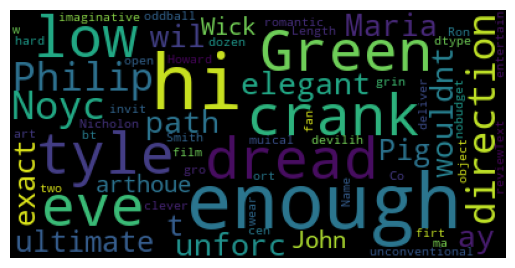

In [17]:
wc_neg=WordCloud().generate(str(testData.reviewText))
plt.imshow(wc_neg)
plt.axis('off')

**Stratified Data Splitting**

In [18]:
y=trainData.sentiment
X=trainData.reviewText
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42, stratify=y)

**Essembling TfidfVectorizer, TruncatedSVD and StandardScaler using a pipeline**

In [ ]:
# Create a pipeline with SimpleImputer and StandardScaler
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svd' , TruncatedSVD(n_components=1000)),
    ('scaler', StandardScaler(with_mean=False))
])

# Fit the pipeline on the training data and transform it
X_train = pipeline.fit_transform(X_train)

# Transform the test data using the fitted pipeline
X_test = pipeline.transform(X_test)

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# # Create a pipeline with SimpleImputer and StandardScaler
# pipeline = Pipeline([
#     ('tfidf', TfidfVectorizer()),
#     ('svd' , TruncatedSVD(n_components=1000)),
#     ('scaler', MinMaxScaler())
# ])

# # Fit the pipeline on the training data and transform it
# X_train = pipeline.fit_transform(X_train)

# # Transform the test data using the fitted pipeline
# X_test = pipeline.transform(X_test)

In [ ]:
testtext=pipeline.transform(testData.reviewText)

In [ ]:
lb=LabelBinarizer()
y_train=lb.fit_transform(y_train)
y_test=lb.transform(y_test)

In [ ]:
print(trainData.isna().sum())
print(trainData.sentiment.isnull().values.any())

**Logistic Regression**

In [ ]:
logreg = LogisticRegression(solver='liblinear',penalty='l2',C=10)
logreg.fit(X_train,y_train)

# Perform k-fold cross-validation (k=5 in this example)
cv_scores = cross_val_score(logreg, X_test, y_test, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean accuracy:", np.mean(cv_scores))


In [ ]:
param_dist = {
    'C': [0.1, 1.0, 10.0],          # Regularization strength
    'penalty': ['l1', 'l2'],        # Regularization type
    'solver': ['liblinear', 'saga'] # Optimization algorithm
}
logreg = LogisticRegression()

# Create the RandomizedCV object
random_search_lr = RandomizedSearchCV(logreg, param_distributions=param_dist, cv=5, scoring='accuracy', random_state=42,n_iter=1)

# Fit the RandomizedSearchCV
random_search_lr.fit(X_train, y_train)

In [ ]:
# Print the best hyperparameters and corresponding accuracy score
print("Best Hyperparameters:", random_search_lr.best_params_)
print("Best Accuracy:", random_search_lr.best_score_)

In [ ]:
y_pred = logreg.predict(X_test)
cm = confusion_matrix(y_pred, y_test)
accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)

# Print the results
print("Confusion Matrix:")
print(cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

from sklearn.metrics import log_loss

print(log_loss(y_test, y_pred))

In [ ]:
print(f1_score(y_test, y_pred, average='macro'))
print(f1_score(y_test, y_pred, average='micro'))
print(f1_score(y_test, y_pred, average='weighted'))
print(f1_score(y_test, y_pred, average=None))
print(f1_score(y_test, y_pred, zero_division=0.0))

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()

In [ ]:
target_names = ['0', '1']
print(classification_report(y_test, y_pred, target_names=target_names))

In [ ]:
display = PrecisionRecallDisplay.from_estimator(logreg, X_test, y_test, name="Logistic Regression")
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [ ]:
prediction=logreg.predict(testtext)
labels = np.where(prediction == 1, "POSITIVE", "NEGATIVE")

In [ ]:
submission = pd.DataFrame(columns = ['id','sentiment'])
submission['id']=[i for i in range(len(prediction))]
submission['sentiment']=labels
submission.to_csv('submission.csv', index=False)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=11,weights='uniform',p=2)
knn.fit(X_train,y_train)
y_pred_knn=knn.predict(X_test)
acc=accuracy_score(y_pred_knn,y_test)
print(acc)

In [ ]:
cm = confusion_matrix(y_pred_knn, y_test)
accuracy = accuracy_score(y_pred_knn, y_test)
precision = precision_score(y_pred_knn, y_test)
recall = recall_score(y_pred_knn, y_test)

# Print the results
print("Confusion Matrix:")
print(cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

In [ ]:
print(f1_score(y_test, y_pred_knn, average='macro'))
print(f1_score(y_test, y_pred_knn, average='micro'))
print(f1_score(y_test, y_pred_knn, average='weighted'))
print(f1_score(y_test, y_pred_knn, average=None))
print(f1_score(y_test, y_pred_knn, zero_division=0.0))

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()

In [ ]:
target_names = ['0', '1']
print(classification_report(y_test, y_pred_knn, target_names=target_names))

In [ ]:
display = PrecisionRecallDisplay.from_estimator(knn, X_test, y_test, name="KNN")
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [ ]:
knn_classifier = KNeighborsClassifier()

# Define the hyperparameter grid to search
param_grid = {
    'n_neighbors': [5,7,11],           # Number of neighbors to consider
    'weights': ['uniform', 'distance'],  # Weighting scheme ('uniform' or 'distance')
    'p': [1, 2]                         # Power parameter for the Minkowski distance (1: Manhattan, 2: Euclidean)
}
random_search_kn = RandomizedSearchCV(knn_classifier, param_distributions=param_grid, cv=5, scoring='accuracy', random_state=42, n_iter=1)

# Fit the RandomizedSearchCV
random_search_kn.fit(X_train, y_train)

# Print the best hyperparameters and corresponding accuracy score
print("Best Hyperparameters:", random_search_kn.best_params_)
print("Best Accuracy:", random_search_kn.best_score_)


In [ ]:
# Create an SVM classifier instance
svm_classifier = SVC(gamma='scale',max_iter=100, kernel='poly', C=0.1)

# Train the SVM classifier
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_SVM = svm_classifier.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred_SVM)
print("Accuracy: {:.7f}%".format(accuracy * 100))

In [ ]:
cm = confusion_matrix(y_pred_SVM, y_test)
accuracy = accuracy_score(y_pred_SVM, y_test)
precision = precision_score(y_pred_SVM, y_test)
recall = recall_score(y_pred_SVM, y_test)

# Print the results
print("Confusion Matrix:")
print(cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

In [ ]:
print(f1_score(y_test, y_pred_SVM, average='macro'))
print(f1_score(y_test, y_pred_SVM, average='micro'))
print(f1_score(y_test, y_pred_SVM, average='weighted'))
print(f1_score(y_test, y_pred_SVM, average=None))
print(f1_score(y_test, y_pred_SVM, zero_division=0.0))

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()

In [ ]:
target_names = ['0', '1']
print(classification_report(y_test, y_pred_SVM, target_names=target_names))

In [ ]:
display = PrecisionRecallDisplay.from_estimator(svm_classifier, X_test, y_test, name="SVC")
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],          # Regularization parameter
    'kernel': ['sigmoid', 'poly'],  # Kernel type
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf' kernel
}

# Create the SVM classifier
svm = SVC(max_iter=10)

# Create GridSearchCV object with cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Evaluate the best model on the test set
accuracy = best_model.score(X_test, y_test)
print("Test Accuracy:", accuracy)

In [ ]:
params = {
    'criterion': 'gini',
    'max_depth': 5,
    'min_samples_leaf': 4,
    'min_samples_split': 2
}

# Create a Decision Tree classifier with the specified parameters
DC = DecisionTreeClassifier(**params)

# Train the classifier on the training data
DC.fit(X_train, y_train)

# Make predictions on the test data
y_pred_DC = DC.predict(X_test)

# Calculate the accuracy of the classifier
accuracy_DC = accuracy_score(y_test, y_pred_DC)
print("Accuracy: ",accuracy_DC)

In [ ]:
cm = confusion_matrix(y_pred_DC, y_test)
accuracy = accuracy_score(y_pred_DC, y_test)
precision = precision_score(y_pred_DC, y_test)
recall = recall_score(y_pred_DC, y_test)

# Print the results
print("Confusion Matrix:")
print(cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

In [ ]:
print(f1_score(y_test, y_pred_DC, average='macro'))
print(f1_score(y_test, y_pred_DC, average='micro'))
print(f1_score(y_test, y_pred_DC, average='weighted'))
print(f1_score(y_test, y_pred_DC, average=None))
print(f1_score(y_test, y_pred_DC, zero_division=0.0))

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()

In [ ]:
target_names = ['0', '1']
print(classification_report(y_test, y_pred_DC, target_names=target_names))

In [ ]:
display = PrecisionRecallDisplay.from_estimator(DC, X_test, y_test, name="Decision Tree Classifier")
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [ ]:
# print(precision_score(y_pred,y_test))

In [ ]:
# prediction=clf.predict(testtext)
# labels = np.where(prediction == 1, "POSITIVE", "NEGATIVE")
# submission = pd.DataFrame(columns = ['id','sentiment'])
# submission['id']=[i for i in range(len(prediction))]
# submission['sentiment']=labels
# submission.to_csv('submission.csv', index=False)

In [ ]:
# Create a Decision Tree classifier
dt = DecisionTreeClassifier()

# Define the parameter grid for hyperparameter tuning
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a RandomizedSearchCV instance
random_search_DC = RandomizedSearchCV(dt, param_distributions=params, cv=5, scoring='accuracy', random_state=42, n_iter=1)


# Perform random search on the training data
random_search_DC.fit(X_train, y_train)

# Get the best parameters and best score from the random search
best_params = random_search_DC.best_params_
best_score = random_search_DC.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)



In [ ]:
# from sklearn.neural_network import MLPClassifier

# # Create a base model (Decision Tree classifier)
# base_model = MLPClassifier()


# # Create a Bagging classifier with base model
# bagging_model = BaggingClassifier(base_model, n_estimators=10, random_state=42)

# # Train the Bagging classifier on the training data
# bagging_model.fit(X_train, y_train)

# # Make predictions on the test data
# y_pred = bagging_model.predict(X_test)

# # Calculate the accuracy of the Bagging classifier
# accuracy = accuracy_score(y_test, y_pred)
# print("Bagging Accuracy: ",accuracy)


In [ ]:
# # Create a base model (Decision Tree classifier)
# base_model = DecisionTreeClassifier(max_depth=1)  # Stump (depth=1 tree)

# # Create an AdaBoost classifier with base model
# adaboost_model = AdaBoostClassifier(base_model, n_estimators=50, random_state=42)

# # Train the AdaBoost classifier on the training data
# adaboost_model.fit(X_train, y_train)

# # Make predictions on the test data
# y_pred = adaboost_model.predict(X_test)

# # Calculate the accuracy of the AdaBoost classifier
# accuracy = accuracy_score(y_test, y_pred)
# print("AdaBoost Accuracy: ",accuracy)


In [ ]:
# np.unique(y_pred)

In [ ]:
# # Create an MLP classifier
# mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

# # Train the MLP classifier on the training data
# mlp_classifier.fit(X_train, y_train)

# # Make predictions on the test data
# y_pred = mlp_classifier.predict(X_test)

# # Calculate the accuracy of the MLP classifier
# accuracy = accuracy_score(y_test, y_pred)
# print("MLP Accuracy: ",accuracy)


In [ ]:
# # Create an MLP classifier
# mlp_classifier = MLPClassifier()

# # Define the parameter grid for hyperparameter tuning
# param_grid = {
#     'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
#     'activation': ['logistic', 'relu'],
#     'solver': ['adam', 'sgd'],
#     'max_iter': [100, 200, 500],
#     'random_state': [42]
# }

# # Create a GridSearchCV instance
# grid_search = GridSearchCV(estimator=mlp_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# # Perform grid search on the training data
# grid_search.fit(X_train, y_train)

# # Get the best parameters and best score from the grid search
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print("Best Parameters:", best_params)
# print("Best Score:", best_score)

# # Train the MLP classifier with the best parameters on the entire training data
# best_mlp_classifier = MLPClassifier(**best_params)
# best_mlp_classifier.fit(X_train, y_train)

# # Make predictions on the test data using the best classifier
# y_pred = best_mlp_classifier.predict(X_test)

# # Calculate the accuracy of the best MLP classifier
# accuracy = accuracy_score(y_test, y_pred)
# print("Test Accuracy using Best MLP:", accuracy)


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

params = {
    'activation': 'logistic',
    'hidden_layer_sizes': (50,),
    'max_iter': 100,
    'random_state': 42,
    'solver': 'adam',
}

# Create an MLP classifier with the provided parameters
mlp = MLPClassifier(**params)
mlp.fit(X_train,y_train)
y_pred_mlp=mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_mlp)
print(accuracy)


In [ ]:
from sklearn.metrics import log_loss

print(log_loss(y_test, y_pred_mlp))

In [ ]:
cm = confusion_matrix(y_pred_mlp, y_test)
accuracy = accuracy_score(y_pred_mlp, y_test)
precision = precision_score(y_pred_mlp, y_test)
recall = recall_score(y_pred_mlp, y_test)

# Print the results
print("Confusion Matrix:")
print(cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

In [ ]:
print(f1_score(y_test, y_pred_mlp, average='macro'))
print(f1_score(y_test, y_pred_mlp, average='micro'))
print(f1_score(y_test, y_pred_mlp, average='weighted'))
print(f1_score(y_test, y_pred_mlp, average=None))
print(f1_score(y_test, y_pred_mlp, zero_division=0.0))

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()

In [ ]:
target_names = ['0', '1']
print(classification_report(y_test, y_pred_mlp, target_names=target_names))

In [ ]:
display = PrecisionRecallDisplay.from_estimator(mlp, X_test, y_test, name="MLP")
_ = display.ax_.set_title("2-class Precision-Recall curve")

|                    | Accuracy      | Precision     | Recall        | F1score       |
|--------------------|---------------|---------------|---------------|---------------|
| Logistic Regression| 0.85874   | 0.93284  | 0.86347  | 0.89682  |
| KNN                | 0.84262  | 0.88468   | 0.88013  | 0.88240  |
| DecisionTree Classifier | 0.72800 | 0.96255  | 0.72229  | 0.82529  |
| MLP classifier     | 0.91125  | 0.94786  | 0.92142  | 0.93445  |
| SVM                | 0.66743  | 1             | 0.66743  | 0.80055  |


Logistic Regression:

Insight: Logistic regression performs well across all metrics.

Justification: Logistic regression is a widely used and robust classification algorithm. It is known for its simplicity, interpretability, and effectiveness in a wide range of applications. In this case, it achieves high accuracy, precision, recall, and F1 score, indicating that it is a well-balanced model for the given classification task.


K-Nearest Neighbors (KNN):

Insight: KNN also performs well but slightly lower than logistic regression in terms of accuracy and F1 score.

Justification: KNN is a non-parametric algorithm that makes predictions based on the majority class of its k-nearest neighbors. In this case, KNN's performance is strong, but it falls slightly behind logistic regression.


Decision Tree Classifier:

Insight: The decision tree classifier achieves high precision but relatively lower accuracy and recall. It seems to suffer from overfitting, as indicated by the large gap between precision and recall.

Justification: Decision trees have a tendency to overfit the training data when they are not pruned. In this case, the model achieves high precision, indicating that it correctly identifies many positive cases (low false positives). However, the lower recall suggests that it fails to capture a significant portion of the positive cases, which is a sign of overfitting.


MLP Classifier:

Insight: The MLP classifier (a neural network) performs impressively well across all metrics. It has the highest accuracy and a good balance between precision and recall, indicating strong generalization capabilities.

Justification: Neural networks, such as MLPs, are highly flexible models capable of learning complex patterns in data. In this case, the MLP performs exceptionally well across all metrics, demonstrating its ability to capture intricate relationships in the dataset. The high accuracy, precision, recall, and F1 score indicate that it generalizes effectively.


Support Vector Machine (SVM):

Insight: The SVM achieves perfect precision, but it has lower accuracy and recall compared to the other models, indicating that it may not perform as well in this specific context.

Justification: SVMs are known for their ability to find a hyperplane that maximizes the margin between classes. In this case, the SVM achieves perfect precision, which means it rarely makes false positive errors. However, the lower accuracy and recall suggest that the model might not be well-suited for this specific classification task, as it appears to prioritize precision at the expense of overall performance.

**Conclusions**:

The choice of the best model depends on the trade-offs between precision and recall.
* If precision is crucial (minimizing false positives), the SVM might be considered.
* If a balance between precision and recall is desired, logistic regression or KNN could be good choices.
* If overall performance is the top priority, the MLP classifier outperforms the other models in this evaluation.
* The decision tree classifier appears to overfit the data, as evidenced by its high precision but relatively lower recall.

Consider the MNIST dataset, split it into training and test set in 50:50 ratio with `random_state = 42`. Fit a SVM model using pipeline with StandardScalar, SVM classifier `kernel='poly'` and `degree = 3`,  `decision_function_shape='ovr'`and `class_weight='balanced'`, `C=10`. Train the model on training data, and make predictions for test data. Generate the Classification report and choose the correct value for weighted avg of f1_score.

In [ ]:
from sklearn.datasets import load_digits
X,y = load_digits(return_X_y=True)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.5, random_state=42)

In [ ]:
from sklearn.svm import SVC
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='poly',degree=3,decision_function_shape='ovr',class_weight='balanced',C=10))
])

# Fit the pipeline on the training data and transform it
X_train = pipeline.fit(X_train,y_train)
# Transform the test data using the fitted pipeline
pipeline.score(X_test, y_test)

In [1]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score
import joblib

In [3]:
dataset = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv')
print(f"Dataset shape : {dataset.shape}\n")
print(f"Dataset head : \n{dataset.head()}\n")

Dataset shape : (162758, 5)

Dataset head : 
                                             movieid         reviewerName  \
0                                   marvelous_pirate       Benjamin Henry   
1          tony_montana_frodo_baggins_v_rocky_balboa        Felicia Lopez   
2  darth_vader_katniss_everdeen_sorcerer_donnie_d...  Mr. Charles Burgess   
3                                 lara_croft_glimmer         Ryan Barrett   
4  jason_bourne_surreal_the_terminator_indiana_jones     Alexander Glover   

   isFrequentReviewer                                         reviewText  \
0               False  Henry Selick’s first movie since 2009’s Corali...   
1               False  With a cast that reads like the Vogue Oscar pa...   
2                True  Creed II does not give us anything but another...   
3               False  I know what you're thinking, but this is no Li...   
4               False  Director Fernando Meirelles tells the story wi...   

  sentiment  
0  POSITIVE  
1  NEGA

In [4]:
print(f"Dataset output counts:\n{dataset.sentiment.value_counts()}\n")

Dataset output counts:
POSITIVE    108761
NEGATIVE     53997
Name: sentiment, dtype: int64



In [5]:
def clean(text):
    if isinstance(text, str):
        cleaned = re.compile(r'<.*?>')
        return re.sub(cleaned, '', text)
    else:
        return text

dataset.reviewText = dataset.reviewText.apply(clean)
print(f"Review sample after removing HTML tags : \n{dataset.reviewText[0]}\n")

Review sample after removing HTML tags : 
Henry Selick’s first movie since 2009’s Coraline. His fifth stop-motion masterpiece.



In [6]:
def is_special(text):
    if isinstance(text, str):
        rem = ''
        for i in text:
            if i.isalnum():
                rem = rem + i
            else:
                rem = rem + ' '
        return rem
    else:
        return str(text)

dataset.reviewText = dataset.reviewText.apply(is_special)
print(f"Review sample after removing special characters : \n{dataset.reviewText[0]}\n")

Review sample after removing special characters : 
Henry Selick s first movie since 2009 s Coraline  His fifth stop motion masterpiece 



In [7]:
def to_lower(text):
    return text.lower()

dataset.reviewText = dataset.reviewText.apply(to_lower)
print(f"Review sample after converting everything to lowercase : \n{dataset.reviewText[0]}\n")

Review sample after converting everything to lowercase : 
henry selick s first movie since 2009 s coraline  his fifth stop motion masterpiece 



In [8]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
def rem_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    return [w for w in words if w not in stop_words]

dataset.reviewText = dataset.reviewText.apply(rem_stopwords)
print(f"Review sample after removing stopwords : \n{dataset.reviewText[0]}\n")

Review sample after removing stopwords : 
['henry', 'selick', 'first', 'movie', 'since', '2009', 'coraline', 'fifth', 'stop', 'motion', 'masterpiece']



In [ ]:
def stem_txt(text):
    ss = SnowballStemmer('english')
    return " ".join([ss.stem(w) for w in text])

dataset.reviewText = dataset.reviewText.apply(stem_txt)
print(f"Review sample after stemming the words : \n{dataset.reviewText[0]}\n")

In [ ]:
mean_review_length = dataset['reviewText'].str.len().mean()
dataset['reviewText'].fillna('NA', inplace=True)

In [ ]:
from sklearn.svm import SVC

X = np.array(dataset.iloc[:, 4].values)
y = np.array(dataset.sentiment.values)

# Word Embeddings using Word2Vec
# sentences = [word_tokenize(review) for review in dataset.reviewText]
# word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# # Vectorize using Word Embeddings
# X_w2v = np.array([np.mean([word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
#                            or [np.zeros(100)], axis=0) for words in sentences])

# # Vectorize using TF-IDF
# tfidf_vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))
# X_tfidf = tfidf_vectorizer.fit_transform(dataset.reviewText).toarray()

# # Combine both TF-IDF and Word Embeddings features
# X_combined = np.concatenate([X_tfidf, X_w2v], axis=1)

# Vectorize using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))
X_tfidf = tfidf_vectorizer.fit_transform(dataset.reviewText).toarray()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, dataset.sentiment.values, test_size=0.2, random_state=9)

# Support Vector Machine (SVM) classifier
svm_classifier = SVC(kernel='linear', C=1.0, random_state=9)

# Train the SVM model
svm_classifier.fit(X_train, y_train)

# Test accuracy
y_pred_svm = svm_classifier.predict(X_test)
test_accuracy_svm = accuracy_score(y_test, y_pred_svm)

print("SVM Model:")
print(f"  Test Accuracy: {test_accuracy_svm * 100:.2f}%")